In [61]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [1]:
conda install tensorflow

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/nattayapiasa/opt/anaconda3

  added / updated specs:
    - tensorflow


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _tflow_select-2.2.0        |            eigen           3 KB
    abseil-cpp-20211102.0      |       he9d5cce_0         933 KB
    absl-py-1.3.0              |   py39hecd8cb5_0         168 KB
    aiohttp-3.8.3              |   py39h6c40b1e_0         428 KB
    aiosignal-1.2.0            |     pyhd3eb1b0_0          12 KB
    a

tensorflow-2.9.1     | 4 KB      | ##################################### | 100% 
curl-7.87.0          | 83 KB     | ##################################### | 100% 
re2-2022.04.01       | 179 KB    | ##################################### | 100% 
tensorboard-data-ser | 2.8 MB    | ##################################### | 100% 
requests-oauthlib-1. | 23 KB     | ##################################### | 100% 
cachetools-4.2.2     | 13 KB     | ##################################### | 100% 
protobuf-3.20.1      | 279 KB    | ##################################### | 100% 
python-flatbuffers-1 | 24 KB     | ##################################### | 100% 
google-pasta-0.2.0   | 46 KB     | ##################################### | 100% 
absl-py-1.3.0        | 168 KB    | ##################################### | 100% 
rsa-4.7.2            | 28 KB     | ##################################### | 100% 
tensorboard-2.9.0    | 5.5 MB    | ##################################### | 100% 
yarl-1.8.1           | 82 KB

In [67]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [8]:
#Check Class Name
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
print(f'number of data in one batch : {len(dataset)}')

number of data in one batch : 68


In [12]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 2 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1]


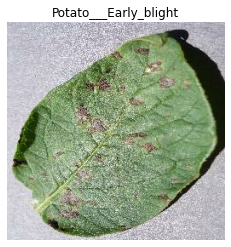

In [17]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8")) #Give a plot array
    plt.axis("off")
    #Display label
    plt.title(class_names[label_batch[0]]) #classname[index]


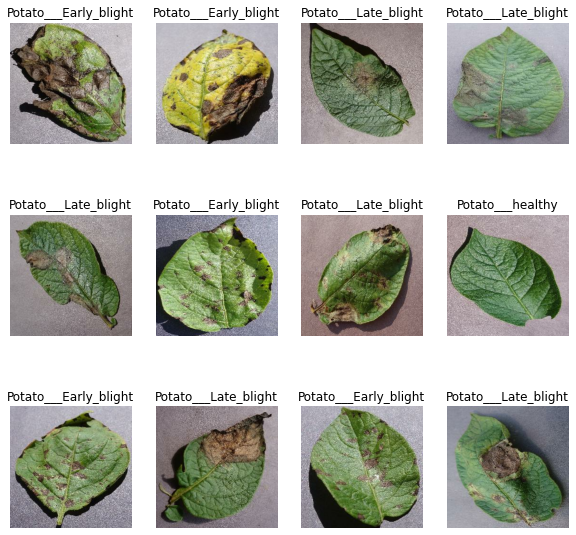

In [22]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1) #subplot(nrows, ncols, index)
        plt.imshow(image_batch[i].numpy().astype("uint8")) #Give a plot array
        plt.axis("off")
        #Display label
        plt.title(class_names[label_batch[i]]) #classname[index]


## Spliting data

In [23]:
#Hard code
train_ds = dataset.take(54)  #54 calculated from len(df)*0.8
#the remaining are val and test
test_ds = dataset.skip(54)
#Val_size = 0.1
val_ds = test_ds.take(6) #6 calculated from len(df)*0.2
#test set
test_ds = test_ds.skip(6)


In [26]:
def split_data_tf(ds, train_split = 0.8, val_split = 0.1, shuffle = True, shuffle_size = 1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds, test_ds

In [35]:
train_ds, val_ds, test_ds = split_data_tf(dataset)

In [38]:
#Optimize the performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds =  val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds =  test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [41]:
resized_dt = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    #Scaling image to 255
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [46]:
augmented_dt = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

## Modeling

In [53]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resized_dt,
    augmented_dt,
    #convolutional layer
    layers.Conv2D(32, (3,3), activation= 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = "softmax")
])

model.build(input_shape = input_shape)

In [54]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_22 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [58]:
#Compile the meodel

model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [68]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/25
54/54 [==============================] - 57s 1s/step - loss: 0.0312 - accuracy: 0.9867 - val_loss: 0.1290 - val_accuracy: 0.9427
Epoch 2/25
54/54 [==============================] - 56s 1s/step - loss: 0.0927 - accuracy: 0.9647 - val_loss: 0.0656 - val_accuracy: 0.9635
Epoch 3/25
54/54 [==============================] - 57s 1s/step - loss: 0.0490 - accuracy: 0.9855 - val_loss: 0.0402 - val_accuracy: 0.9844
Epoch 4/25
54/54 [==============================] - 56s 1s/step - loss: 0.0349 - accuracy: 0.9884 - val_loss: 0.0188 - val_accuracy: 0.9896
Epoch 5/25
54/54 [==============================] - 55s 1s/step - loss: 0.0341 - accuracy: 0.9907 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 6/25
54/54 [==============================] - 55s 1s/step - loss: 0.0190 - accuracy: 0.9954 - val_loss: 0.0408 - val_accuracy: 0.9844
Epoch 7/25
54/54 [==============================] - 55s 1s/step - loss: 0.0179 - accuracy: 0.9959 - val_loss: 0.0144 - val_accuracy: 0.9896
Epoch 8/25
54/54 [==

In [69]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 328ms/step - loss: 0.0071 - accuracy: 1.0000


In [70]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

In [71]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and Validation loss')

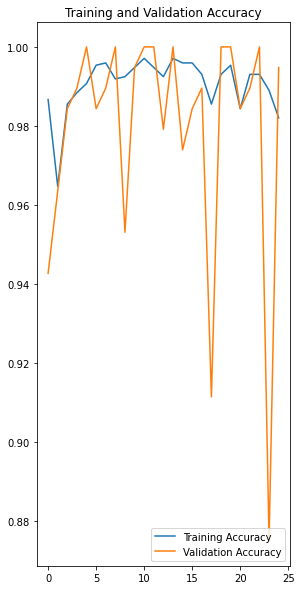

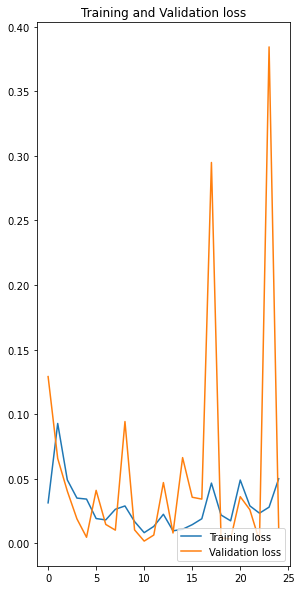

In [76]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

#Plot loss
plt.figure(figsize = (10,10))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = "Validation loss")
plt.legend(loc = "lower right")
plt.title("Training and Validation loss")

## Testing

[[[204. 199. 205.]
  [196. 191. 197.]
  [184. 179. 185.]
  ...
  [170. 169. 175.]
  [169. 168. 174.]
  [190. 189. 195.]]

 [[204. 199. 205.]
  [200. 195. 201.]
  [189. 184. 190.]
  ...
  [183. 182. 188.]
  [168. 167. 173.]
  [176. 175. 181.]]

 [[193. 188. 194.]
  [195. 190. 196.]
  [193. 188. 194.]
  ...
  [205. 204. 210.]
  [187. 186. 192.]
  [179. 178. 184.]]

 ...

 [[163. 157. 161.]
  [159. 153. 157.]
  [169. 163. 167.]
  ...
  [155. 150. 156.]
  [171. 166. 172.]
  [164. 159. 165.]]

 [[155. 149. 153.]
  [146. 140. 144.]
  [155. 149. 153.]
  ...
  [149. 144. 150.]
  [152. 147. 153.]
  [144. 139. 145.]]

 [[173. 167. 171.]
  [158. 152. 156.]
  [163. 157. 161.]
  ...
  [170. 165. 171.]
  [164. 159. 165.]
  [155. 150. 156.]]]
tf.Tensor(0, shape=(), dtype=int32)
first image of testing
actual label: Potato___Early_blight
1/1 [==============================] - 0s 418ms/step
predicted label: Potato___Early_blight


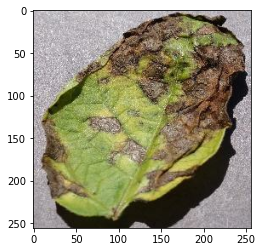

In [81]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
    print(image_batch[0].numpy())
    print(label_batch[0])
    # plot image
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    
    print("first image of testing")
    plt.imshow(first_image)
    print("actual label:" , class_names[first_label])
    #predict
    predict = model.predict(image_batch)
    print("predicted label:", class_names[np.argmax(predict[0])])

In [98]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


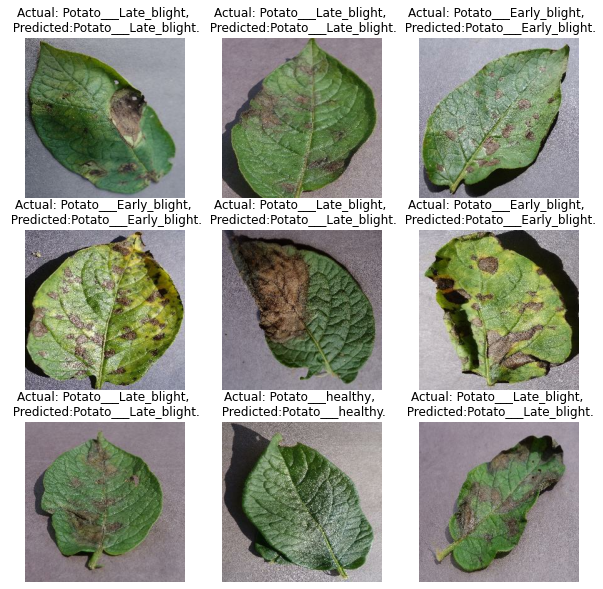

In [100]:
plt.figure(figsize = (10,10))
for image, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i +1)
        plt.imshow(image[i].numpy().astype("uint8"))
        
        predicted_class, confidece = predict(model, image[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted:{predicted_class}.")
        
        plt.axis("off")

In [102]:
model_version = 1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1/assets


INFO:tensorflow:Assets written to: ../model/1/assets
